<img src="https://www.ismiletechnologies.com/wp-content/uploads/2021/09/Feature-Engineering-in-machine-learning.png"
     width="1300" 
     height="200" />

In [0]:
# data manipulation  functions
from pyspark.sql.functions import *
import numpy as np
import pandas as pd

# visualisation
#import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.correlation import plot_corr
from scipy.stats import skew
from scipy.stats import kurtosis
import statistics
%matplotlib inline
#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

# Pyspark
import pyspark
from pyspark.sql import SparkSession

#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [0]:
# spark session
spark = SparkSession.builder.appName('engineering').getOrCreate()

In [0]:
data_set = sqlContext.sql('SELECT * FROM lake_data')

In [0]:
new_data_set = data_set.na.drop()

In [0]:
new_data_set.show()

+----------+----------------+----------------+----------------+------------------+-----------------+--------------------+----------+---------+
|      Date|Rainfall_S_Piero|Rainfall_Mangona|Rainfall_S_Agata|Rainfall_Cavallina|Rainfall_Le_Croci|Temperature_Le_Croci|Lake_Level|Flow_Rate|
+----------+----------------+----------------+----------------+------------------+-----------------+--------------------+----------+---------+
|02/01/2004|             0.0|             0.0|             0.0|               0.0|              0.0|                 6.5|    251.21|      0.5|
|03/01/2004|             0.0|             0.0|             0.0|               0.0|              0.0|                4.45|    251.28|      0.5|
|04/01/2004|             0.0|             0.0|             0.0|               0.0|              0.0|                 2.0|    251.35|      0.5|
|05/01/2004|             0.2|             0.0|             0.0|               0.0|              0.0|                 0.9|    251.37|      0.5|

####Features from the date

The model will forecasts lake water availability in terms of level or water flow in a given time interval of the year. The time interval is defined as day/month depending on the time unit the model works on (for instance, for a model working on a monthly interval a forecast over the month is expected). Hence we need to engineer day, month and year features. This allows us to experiment with different intervals and use whichsover allows better predictability.

In [0]:
#Changing the date to correct datatype

data = new_data_set.withColumn('new_date',to_date("Date","dd/MM/yyyy"))

# new data frame with correct datatypes

df = data.select(['new_date',
 'Rainfall_S_Piero',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci',
 'Temperature_Le_Croci',
 'Lake_Level',
 'Flow_Rate'])

# renaming date

df = df.withColumnRenamed('new_date','Date')

In [0]:
# Month
df_analysis = df.withColumn('Month', month(df['Date']))

# dayofmonth
df_analysis = df_analysis.withColumn('Day_of_Month', dayofmonth(df['Date']))

# year
df_analysis = df_analysis.withColumn('Year', year(df['Date']))

In [0]:
df_analysis.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Rainfall_S_Piero: double (nullable = true)
 |-- Rainfall_Mangona: double (nullable = true)
 |-- Rainfall_S_Agata: double (nullable = true)
 |-- Rainfall_Cavallina: double (nullable = true)
 |-- Rainfall_Le_Croci: double (nullable = true)
 |-- Temperature_Le_Croci: double (nullable = true)
 |-- Lake_Level: double (nullable = true)
 |-- Flow_Rate: double (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day_of_Month: integer (nullable = true)
 |-- Year: integer (nullable = true)



In [0]:
df_analysis.columns

Out[121]: ['Date',
 'Rainfall_S_Piero',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci',
 'Temperature_Le_Croci',
 'Lake_Level',
 'Flow_Rate',
 'Month',
 'Day_of_Month',
 'Year']

###Feature from Rainfall data

In [0]:
df_analysis.show()

+----------+----------------+----------------+----------------+------------------+-----------------+--------------------+----------+---------+-----+------------+----+
|      Date|Rainfall_S_Piero|Rainfall_Mangona|Rainfall_S_Agata|Rainfall_Cavallina|Rainfall_Le_Croci|Temperature_Le_Croci|Lake_Level|Flow_Rate|Month|Day_of_Month|Year|
+----------+----------------+----------------+----------------+------------------+-----------------+--------------------+----------+---------+-----+------------+----+
|2004-01-02|             0.0|             0.0|             0.0|               0.0|              0.0|                 6.5|    251.21|      0.5|    1|           2|2004|
|2004-01-03|             0.0|             0.0|             0.0|               0.0|              0.0|                4.45|    251.28|      0.5|    1|           3|2004|
|2004-01-04|             0.0|             0.0|             0.0|               0.0|              0.0|                 2.0|    251.35|      0.5|    1|           4|2004

#### Data in daily intervals

In [0]:
df_1 = df_analysis.withColumn("mean_of_Rainfall", 
                    (col("Rainfall_S_Piero") + col("Rainfall_Mangona") + col('Rainfall_S_Agata') + col("Rainfall_Cavallina") + col("Rainfall_Le_Croci"))/5)

df_1.select("mean_of_Rainfall").show()


+------------------+
|  mean_of_Rainfall|
+------------------+
|               0.0|
|               0.0|
|               0.0|
|              0.04|
|               0.0|
|               0.0|
|              0.16|
|              5.52|
|               0.0|
|               0.0|
|              2.32|
|1.1199999999999999|
|              0.04|
| 8.959999999999999|
| 5.840000000000001|
|              28.8|
|             28.76|
|              0.04|
|              0.04|
|               0.0|
+------------------+
only showing top 20 rows



In [0]:
df_1.columns

Out[124]: ['Date',
 'Rainfall_S_Piero',
 'Rainfall_Mangona',
 'Rainfall_S_Agata',
 'Rainfall_Cavallina',
 'Rainfall_Le_Croci',
 'Temperature_Le_Croci',
 'Lake_Level',
 'Flow_Rate',
 'Month',
 'Day_of_Month',
 'Year',
 'mean_of_Rainfall']

In [0]:
df_avg_day = df_1.select(['Day_of_Month','Month','Year','mean_of_Rainfall','Temperature_Le_Croci','Lake_Level','Flow_Rate'])

####Data in Monthly intervals

In [0]:
df_2 = df_avg_day.groupBy(['year', 'month']).agg(avg("mean_of_Rainfall"), avg('Temperature_Le_Croci'),avg('Lake_Level'),avg('Flow_Rate'))

In [0]:
df_3 = df_2.orderBy(['year','month'])

In [0]:
df_3.columns

Out[128]: ['year',
 'month',
 'avg(mean_of_Rainfall)',
 'avg(Temperature_Le_Croci)',
 'avg(Lake_Level)',
 'avg(Flow_Rate)']

In [0]:

df_avg_month = df_3.withColumnRenamed('avg(mean_of_Rainfall)','avg_Rainfall')

df_avg_month = df_avg_month.withColumnRenamed('avg(Temperature_Le_Croci)', 'avg_Temperature_Le_Croci')

df_avg_month = df_avg_month.withColumnRenamed('avg(Lake_Level)', 'avg_Lake_Level')

df_avg_month = df_avg_month.withColumnRenamed('avg(Flow_Rate)', 'avg_Flow_Rate')

In [0]:
df_avg_month.show()

+----+-----+-------------------+------------------------+------------------+------------------+
|year|month|       avg_Rainfall|avg_Temperature_Le_Croci|    avg_Lake_Level|     avg_Flow_Rate|
+----+-----+-------------------+------------------------+------------------+------------------+
|2004|    1| 3.6960000000000006|       4.195000000000001|251.67766666666665| 6.251666666666667|
|2004|    2|  5.102068965517241|       6.181034482758621| 251.8231034482758| 8.894827586206896|
|2004|    3| 1.8193548387096774|       8.251612903225807| 251.8709677419355|               5.6|
|2004|    4|  2.738666666666667|      12.441666666666666|251.97366666666667|3.7833333333333328|
|2004|    5|  3.905806451612903|      14.679032258064513| 252.0770967741936| 9.241935483870972|
|2004|    6| 0.9146666666666666|       20.09833333333334|251.96866666666665|1.0833333333333341|
|2004|    7|0.42838709677419345|       22.80322580645161|251.41032258064513|1.8709677419354838|
|2004|    8| 0.7458064516129029|       2

In [0]:
df_avg_month.columns

Out[131]: ['year',
 'month',
 'avg_Rainfall',
 'avg_Temperature_Le_Croci',
 'avg_Lake_Level',
 'avg_Flow_Rate']

####Feature Scaling

If the data in any conditions has data points far from each other, scaling is a technique to make them closer to each other or in simpler words, we can say that the scaling is used for making data points generalized so that the distance between them will be lower.

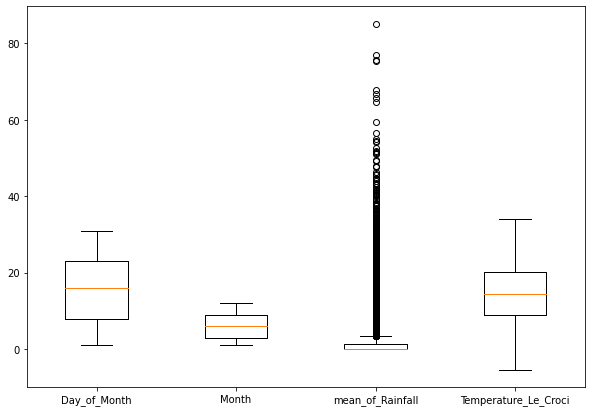

In [0]:
# box plot of unscaled data
df = df_avg_day.select(['Day_of_Month','Month','mean_of_Rainfall','Temperature_Le_Croci']).toPandas()
fig = plt.figure(figsize =(10, 7))
labels = df.columns
plt.boxplot(df)
plt.xticks(np.arange(len(labels))+1,labels)
plt.show()

The plot shows how different feature scales are.

#####Normalization

This method rescales the data where we try to fit all the data points between the range of 0 to 1 so that the data points can become closer to each other.

In [0]:
df_norm = df_avg_day.select(['Day_of_Month','Month','mean_of_Rainfall','Temperature_Le_Croci']).toPandas()

In [0]:
#Instantiate scaler
norm_scaler = MinMaxScaler()

#fit data
norm_scaler.fit(df_norm)

# create scaled version of the predictors
scaled_features = scaler.transform(df_norm)


In [0]:
# convert the scaled predictor values into a dataframe
df_norm_scaled = pd.DataFrame(scaled_features,columns = df_norm.columns)

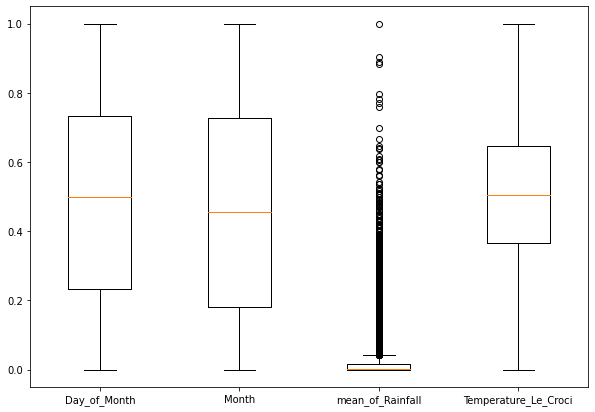

In [0]:
#Box plots of scaled data
fig = plt.figure(figsize =(10, 7))
labels = df_norm_scaled.columns
plt.boxplot(df_norm_scaled)
plt.xticks(np.arange(len(labels))+1,labels)
plt.show()


######Standardization

This method makes data points to be centred about the mean of all the data points presented in a feature with a unit standard deviation. This means the mean of the data point will be zero and the standard deviation will be 1.

In [0]:
df_stnd = df_avg_day.select(['Day_of_Month','Month','mean_of_Rainfall','Temperature_Le_Croci']).toPandas()

In [0]:
#instantiate a scale
stnd_scaler = StandardScaler()

#fit data
stnd_scaler.fit(df_stnd)

# create scaled version of the predictors
scaled_predictors = scaler.transform(df_stnd)

In [0]:
# convert the scaled predictor values into a dataframe
df_stnd_scaled = pd.DataFrame(scaled_predictors,columns = df_stnd.columns)

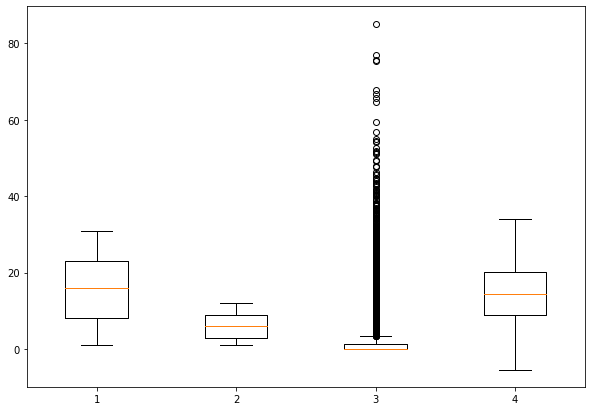

In [0]:
#Box plots of scaled data
fig = plt.figure(figsize =(10, 7))
plt.boxplot(df)
labels = df_norm_scaled.columns
plt.show()

In [0]:
# s
#stddev_rainfall = df_avg_month.agg({'avg_Rainfall': 'stddev'})

In [0]:
#=========================================================MACHINE LEARNING==========================================================

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator